In [1]:
import os
import random
import numpy as np
import pandas as pd
from PIL import Image 
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from sklearn.metrics import confusion_matrix

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import torch
import torchvision
import torch.nn as nn
from tqdm.notebook import trange
import torchvision.models as models
from torch.utils.data import DataLoader
import torchvision.transforms as transforms 

In [3]:
try:
    from torchsummary import summary
except ModuleNotFoundError:
    !pip install torchsummary
    from torchsummary import summary

![](https://www.retinaeyedocs.com/wp-content/uploads/Diabetic-retinopathy-and-normal-eye-retina.jpg.webp)

In [4]:
cwd = "/kaggle/input/diagnosis-of-diabetic-retinopathy"

In [5]:
data_type = ["train", "valid", "test"]
labels = ["No_DR", "DR"]
#
dict_ = {"type": data_type, "DR": [], "No_DR": []}
#
for d in data_type:
    for l in labels:
        path = f"{cwd}/{d}/{l}"
        files_num = len(os.listdir(path))
        dict_[l].append(files_num)
df = pd.DataFrame(dict_)        

In [6]:
fig = go.Figure()
fig.add_trace(go.Histogram(histfunc="sum", y=df["DR"], x=data_type, name="DR"))
fig.add_trace(go.Histogram(histfunc="sum", y=df["No_DR"], x=data_type, name="No_DR"))
fig.show()


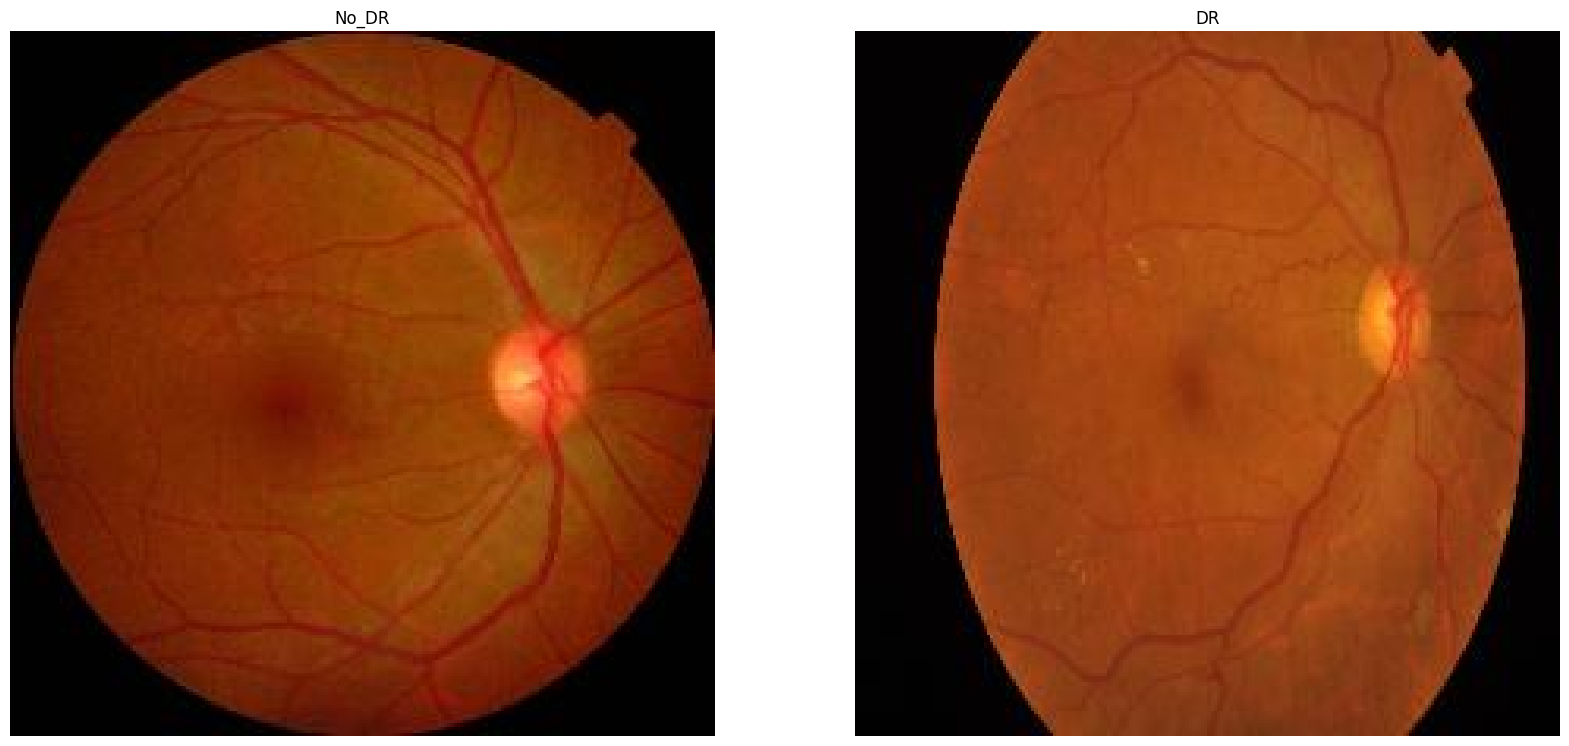

In [7]:
_, axs = plt.subplots(1, 2, figsize=(20, 20))
for row, label in enumerate(labels):
    images_list = os.listdir(f"{cwd}/train/{label}")
    im_path = random.choice(images_list)
    im = Image.open(f"{cwd}/train/{label}/{im_path}")
    axs[row].imshow(np.asarray(im))
    axs[row].axis("off")
    axs[row].set_title(label)

In [8]:
transform = transforms.Compose(
    [transforms.Resize((256, 256)),
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomVerticalFlip(p=0.5),
     transforms.RandomRotation(45),
     transforms.ToTensor()]
)

In [9]:
transform_test = transforms.Compose(
    [transforms.Resize((256, 256)),
     transforms.ToTensor()]
)

In [10]:
train_dataset = torchvision.datasets.ImageFolder(root=f"{cwd}/train", transform=transform)
valid_dataset = torchvision.datasets.ImageFolder(root=f"{cwd}/valid", transform=transform)
test_dataset = torchvision.datasets.ImageFolder(root=f"{cwd}/test", transform=transform_test)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device - {device}")

device - cuda


In [12]:
BATCH_SIZE = 2 ** 3
EPOCHS = 40
LR = 1e-6

In [13]:

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, shuffle=True)
print((test_dataloader))

In [14]:
model = models.vgg16()
model.classifier[-1] = nn.Sequential(nn.Linear(2**12, 2**10),
                                     nn.Linear(2**10, 2**4),
                                     nn.Linear(2**4, 2**1))
model = model.to(device)
summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
         MaxPool2d-5         [-1, 64, 128, 128]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]         147,584
              ReLU-9        [-1, 128, 128, 128]               0
        MaxPool2d-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]         295,168
             ReLU-12          [-1, 256, 64, 64]               0
           Conv2d-13          [-1, 256, 64, 64]         590,080
             ReLU-14          [-1, 256,

In [15]:
def accuracy(y_pred, y):
    y_pred = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    return (y_pred == y).sum().item()/len(y_pred)

In [16]:
class TrainModel:
    def __init__(self, train_dataloader: torch.utils.data.DataLoader, valid_dataloader: torch.utils.data.DataLoader, 
                 test_dataloader: torch.utils.data.DataLoader, model: torch.nn.Module, loss_fn: torch.nn.Module,
                 optimizer: torch.optim.Optimizer, epochs: int, device: str):
        self.dataloader = {"train": train_dataloader, "valid": valid_dataloader, "test": test_dataloader}
        self.results = {"train": {"loss": [], "accuracy": []},
                        "valid": {"loss": [], "accuracy": []}}
        self.model = model
        self.loss_fn = loss_fn
        self.opt = optimizer
        self.epochs = epochs
        self.device = device
        self.conf_mat = None
        self.conf_imgs = np.zeros((2, 2, 3, 256, 256))
        
    def step(self, step_type: str):
        step_loss, step_acc = 0, 0
        num_batches = len(self.dataloader[step_type])
        pbar = trange(num_batches, leave=False)
        for batch, (X, y) in enumerate(self.dataloader[step_type]):
            X, y = X.to(self.device), y.to(self.device)
            y_pred = self.model(X)
            #
            loss = self.loss_fn(y_pred, y)
            step_loss += loss.item() 
            #
            acc = accuracy(y_pred, y)
            step_acc += acc
            #
            pbar.set_description(f"{step_type.capitalize()} | loss={loss:.4f} | accuracy={acc:.4f} ")
            pbar.update()
            #
            if step_type == "train":
                self.opt.zero_grad()
                loss.backward()
                self.opt.step()
        pbar.container.close()
        step_loss /= len(self.dataloader[step_type])
        step_acc /= len(self.dataloader[step_type])
        #
        print(f"{step_type.capitalize()} | loss={step_loss:.4f} | accuracy={step_acc:.4f} ")
        #
        self.results[step_type]["loss"].append(step_loss)
        self.results[step_type]["accuracy"].append(step_acc)
    
    def train_step(self):
        self.model.train()
        self.step(step_type="train")
    
    def valid_step(self):
        self.model.eval()
        with torch.inference_mode():
            self.step(step_type="valid")
    
    def train(self):
        for epoch in trange(self.epochs):
            print(f"Epoch: {epoch+1}/{self.epochs}: ")
            self.train_step()
            self.valid_step()
            print("")
        return self.model
            
    def plot_results(self):
        colors = ["green", "blue"]
        fig = make_subplots(rows=2, cols=1)
        for group_ind, g in enumerate(["loss", "accuracy"]):
            for step_ind, s in enumerate(["train", "valid"]):
                fig.append_trace(go.Scatter(
                    x = np.arange(self.epochs),
                    y = self.results[s][g],
                    mode = "lines",
                    name = f"{s}", 
                    line = dict(color = colors[step_ind]),
                    legendgroup = f"{group_ind+1}"),
                    row = group_ind+1, col = 1)
        fig.update_layout(
            title_text = "Training results", 
            xaxis1_title = "Epochs", yaxis1_title = "Loss",
            xaxis2_title = "Epochs", yaxis2_title = "Accuracy", yaxis2_range=[0, 1],
            legend_tracegroupgap = 180)
        fig.show()  
            
    def plot_confusion_matrix(self):
        labels = ["No_DR", "DR"]
        z_text = [[str(labels) for labels in labels] for labels in self.conf_mat]
        fig = ff.create_annotated_heatmap(self.conf_mat, x=labels, y=labels,
                                          annotation_text=z_text, colorscale="BuGn")
        fig.update_layout(title_text='<i><b>Confusion matrix</b></i>')
        #
        fig.add_annotation(dict(font=dict(color="black",size=14),
                        x=0.5,
                        y=-0.15,
                        showarrow=False,
                        text="Predicted value",
                        xref="paper",
                        yref="paper"))
        #
        fig.add_annotation(dict(font=dict(color="black",size=14),
                        x=-0.15,
                        y=0.5,
                        showarrow=False,
                        text="Real value",
                        textangle=-90,
                        xref="paper",
                        yref="paper"))
        #
        fig.update_layout(margin=dict(t=50, l=200))
        fig["data"][0]["showscale"] = True
        fig.show()
        
    def plot_confusion_summary(self):
        labels = ["No_DR", "DR"]
        _, axs = plt.subplots(2, 2, figsize=(20, 20))
        for r, true in enumerate([0, 1]):
            for c, pred in enumerate([0, 1]):
                axs[r, c].imshow(self.conf_imgs[true, pred, ...].T)
                axs[r, c].axis("off")
                axs[r, c].set_title(f"Ground truth - {labels[true]} | Prediction - {labels[pred]}")
   
    def confusion_matrix(self):
        step_type = "test"
        self.model.eval()
        with torch.inference_mode():
            num_batches = len(self.dataloader[step_type])
            pbar = trange(num_batches, leave=False)
            y_gt, y_prd = [], []
            for batch, (X, y) in enumerate(self.dataloader[step_type]):
                X, y = X.to(self.device), y.to(self.device)
                y_pred = self.model(X)
                y_pred = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
                #
                pbar.set_description(f"Ground truth - {y.item()} | Prediction - {y_pred.item()} ")
                pbar.update()
                #
                if self.conf_imgs[y.item(), y_pred.item(), ...].sum() == 0:
                    self.conf_imgs[y.item(), y_pred.item(), ...] = X.cpu().numpy()
                y_gt.append(y.item())
                y_prd.append(y_pred.item())
        self.conf_mat = confusion_matrix(y_gt, y_prd, normalize="true")
        self.plot_confusion_matrix()
        self.plot_confusion_summary()

In [17]:
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=LR)

In [18]:
session = TrainModel(train_dataloader=train_dataloader, valid_dataloader=valid_dataloader ,test_dataloader=test_dataloader,
                     model=model, loss_fn=loss_fn, optimizer=optimizer, epochs=EPOCHS, device=device)
model = session.train()

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1/40: 


  0%|          | 0/260 [00:00<?, ?it/s]

Train | loss=0.6995 | accuracy=0.5144 


  0%|          | 0/67 [00:00<?, ?it/s]

Valid | loss=0.6901 | accuracy=0.5995 

Epoch: 2/40: 


  0%|          | 0/260 [00:00<?, ?it/s]

Train | loss=0.6875 | accuracy=0.5716 


  0%|          | 0/67 [00:00<?, ?it/s]

Valid | loss=0.6895 | accuracy=0.4832 

Epoch: 3/40: 


  0%|          | 0/260 [00:00<?, ?it/s]

Train | loss=0.6818 | accuracy=0.6058 


  0%|          | 0/67 [00:00<?, ?it/s]

Valid | loss=0.6711 | accuracy=0.7133 

Epoch: 4/40: 


  0%|          | 0/260 [00:00<?, ?it/s]

Train | loss=0.6660 | accuracy=0.6351 


  0%|          | 0/67 [00:00<?, ?it/s]

Valid | loss=0.6637 | accuracy=0.6157 

Epoch: 5/40: 


  0%|          | 0/260 [00:00<?, ?it/s]

Train | loss=0.6371 | accuracy=0.6298 


  0%|          | 0/67 [00:00<?, ?it/s]

Valid | loss=0.6081 | accuracy=0.6157 

Epoch: 6/40: 


  0%|          | 0/260 [00:00<?, ?it/s]

Train | loss=0.5923 | accuracy=0.6591 


  0%|          | 0/67 [00:00<?, ?it/s]

Valid | loss=0.5443 | accuracy=0.7239 

Epoch: 7/40: 


  0%|          | 0/260 [00:00<?, ?it/s]

Train | loss=0.5650 | accuracy=0.6837 


  0%|          | 0/67 [00:00<?, ?it/s]

Valid | loss=0.5752 | accuracy=0.6437 

Epoch: 8/40: 


  0%|          | 0/260 [00:00<?, ?it/s]

Train | loss=0.5149 | accuracy=0.7375 


  0%|          | 0/67 [00:00<?, ?it/s]

Valid | loss=0.4600 | accuracy=0.7954 

Epoch: 9/40: 


  0%|          | 0/260 [00:00<?, ?it/s]

Train | loss=0.4623 | accuracy=0.7928 


  0%|          | 0/67 [00:00<?, ?it/s]

Valid | loss=0.4174 | accuracy=0.8122 

Epoch: 10/40: 


  0%|          | 0/260 [00:00<?, ?it/s]

Train | loss=0.4311 | accuracy=0.8111 


  0%|          | 0/67 [00:00<?, ?it/s]

Valid | loss=0.4281 | accuracy=0.8197 

Epoch: 11/40: 


  0%|          | 0/260 [00:00<?, ?it/s]

Train | loss=0.3906 | accuracy=0.8389 


  0%|          | 0/67 [00:00<?, ?it/s]

Valid | loss=0.3824 | accuracy=0.8271 

Epoch: 12/40: 


  0%|          | 0/260 [00:00<?, ?it/s]

Train | loss=0.3756 | accuracy=0.8452 


  0%|          | 0/67 [00:00<?, ?it/s]

Valid | loss=0.3563 | accuracy=0.8495 

Epoch: 13/40: 


  0%|          | 0/260 [00:00<?, ?it/s]

Train | loss=0.3612 | accuracy=0.8510 


  0%|          | 0/67 [00:00<?, ?it/s]

Valid | loss=0.3624 | accuracy=0.8532 

Epoch: 14/40: 


  0%|          | 0/260 [00:00<?, ?it/s]

Train | loss=0.3441 | accuracy=0.8587 


  0%|          | 0/67 [00:00<?, ?it/s]

Valid | loss=0.3413 | accuracy=0.8514 

Epoch: 15/40: 


  0%|          | 0/260 [00:00<?, ?it/s]

Train | loss=0.3337 | accuracy=0.8620 


  0%|          | 0/67 [00:00<?, ?it/s]

Valid | loss=0.3553 | accuracy=0.8532 

Epoch: 16/40: 


  0%|          | 0/260 [00:00<?, ?it/s]

Train | loss=0.3190 | accuracy=0.8755 


  0%|          | 0/67 [00:00<?, ?it/s]

Valid | loss=0.2868 | accuracy=0.8794 

Epoch: 17/40: 


  0%|          | 0/260 [00:00<?, ?it/s]

Train | loss=0.3077 | accuracy=0.8745 


  0%|          | 0/67 [00:00<?, ?it/s]

Valid | loss=0.2837 | accuracy=0.8756 

Epoch: 18/40: 


  0%|          | 0/260 [00:00<?, ?it/s]

Train | loss=0.3027 | accuracy=0.8803 


  0%|          | 0/67 [00:00<?, ?it/s]

Valid | loss=0.2646 | accuracy=0.8850 

Epoch: 19/40: 


  0%|          | 0/260 [00:00<?, ?it/s]

Train | loss=0.2897 | accuracy=0.8880 


  0%|          | 0/67 [00:00<?, ?it/s]

Valid | loss=0.2662 | accuracy=0.8850 

Epoch: 20/40: 


  0%|          | 0/260 [00:00<?, ?it/s]

Train | loss=0.2907 | accuracy=0.8856 


  0%|          | 0/67 [00:00<?, ?it/s]

Valid | loss=0.2448 | accuracy=0.8961 

Epoch: 21/40: 


  0%|          | 0/260 [00:00<?, ?it/s]

Train | loss=0.2813 | accuracy=0.8885 


  0%|          | 0/67 [00:00<?, ?it/s]

Valid | loss=0.2392 | accuracy=0.9036 

Epoch: 22/40: 


  0%|          | 0/260 [00:00<?, ?it/s]

Train | loss=0.2747 | accuracy=0.8894 


  0%|          | 0/67 [00:00<?, ?it/s]

Valid | loss=0.2802 | accuracy=0.8700 

Epoch: 23/40: 


  0%|          | 0/260 [00:00<?, ?it/s]

Train | loss=0.2624 | accuracy=0.8938 


  0%|          | 0/67 [00:00<?, ?it/s]

Valid | loss=0.2797 | accuracy=0.8644 

Epoch: 24/40: 


  0%|          | 0/260 [00:00<?, ?it/s]

Train | loss=0.2633 | accuracy=0.9043 


  0%|          | 0/67 [00:00<?, ?it/s]

Valid | loss=0.2994 | accuracy=0.8588 

Epoch: 25/40: 


  0%|          | 0/260 [00:00<?, ?it/s]

Train | loss=0.2501 | accuracy=0.9077 


  0%|          | 0/67 [00:00<?, ?it/s]

Valid | loss=0.2258 | accuracy=0.9011 

Epoch: 26/40: 


  0%|          | 0/260 [00:00<?, ?it/s]

Train | loss=0.2497 | accuracy=0.9005 


  0%|          | 0/67 [00:00<?, ?it/s]

Valid | loss=0.2133 | accuracy=0.9092 

Epoch: 27/40: 


  0%|          | 0/260 [00:00<?, ?it/s]

Train | loss=0.2481 | accuracy=0.9010 


  0%|          | 0/67 [00:00<?, ?it/s]

Valid | loss=0.2264 | accuracy=0.9092 

Epoch: 28/40: 


  0%|          | 0/260 [00:00<?, ?it/s]

Train | loss=0.2412 | accuracy=0.9058 


  0%|          | 0/67 [00:00<?, ?it/s]

Valid | loss=0.2184 | accuracy=0.9036 

Epoch: 29/40: 


  0%|          | 0/260 [00:00<?, ?it/s]

Train | loss=0.2419 | accuracy=0.9067 


  0%|          | 0/67 [00:00<?, ?it/s]

Valid | loss=0.2155 | accuracy=0.9055 

Epoch: 30/40: 


  0%|          | 0/260 [00:00<?, ?it/s]

Train | loss=0.2285 | accuracy=0.9144 


  0%|          | 0/67 [00:00<?, ?it/s]

Valid | loss=0.2101 | accuracy=0.9111 

Epoch: 31/40: 


  0%|          | 0/260 [00:00<?, ?it/s]

Train | loss=0.2305 | accuracy=0.9101 


  0%|          | 0/67 [00:00<?, ?it/s]

Valid | loss=0.2434 | accuracy=0.8812 

Epoch: 32/40: 


  0%|          | 0/260 [00:00<?, ?it/s]

Train | loss=0.2247 | accuracy=0.9183 


  0%|          | 0/67 [00:00<?, ?it/s]

Valid | loss=0.2099 | accuracy=0.9111 

Epoch: 33/40: 


  0%|          | 0/260 [00:00<?, ?it/s]

Train | loss=0.2219 | accuracy=0.9183 


  0%|          | 0/67 [00:00<?, ?it/s]

Valid | loss=0.1960 | accuracy=0.9185 

Epoch: 34/40: 


  0%|          | 0/260 [00:00<?, ?it/s]

Train | loss=0.2074 | accuracy=0.9269 


  0%|          | 0/67 [00:00<?, ?it/s]

Valid | loss=0.1849 | accuracy=0.9223 

Epoch: 35/40: 


  0%|          | 0/260 [00:00<?, ?it/s]

Train | loss=0.2134 | accuracy=0.9178 


  0%|          | 0/67 [00:00<?, ?it/s]

Valid | loss=0.1900 | accuracy=0.9185 

Epoch: 36/40: 


  0%|          | 0/260 [00:00<?, ?it/s]

Train | loss=0.2108 | accuracy=0.9284 


  0%|          | 0/67 [00:00<?, ?it/s]

Valid | loss=0.1933 | accuracy=0.9185 

Epoch: 37/40: 


  0%|          | 0/260 [00:00<?, ?it/s]

Train | loss=0.2069 | accuracy=0.9260 


  0%|          | 0/67 [00:00<?, ?it/s]

Valid | loss=0.2036 | accuracy=0.9167 

Epoch: 38/40: 


  0%|          | 0/260 [00:00<?, ?it/s]

Train | loss=0.2044 | accuracy=0.9221 


  0%|          | 0/67 [00:00<?, ?it/s]

Valid | loss=0.2177 | accuracy=0.8999 

Epoch: 39/40: 


  0%|          | 0/260 [00:00<?, ?it/s]

Train | loss=0.1992 | accuracy=0.9245 


  0%|          | 0/67 [00:00<?, ?it/s]

Valid | loss=0.1850 | accuracy=0.9185 

Epoch: 40/40: 


  0%|          | 0/260 [00:00<?, ?it/s]

Train | loss=0.1959 | accuracy=0.9313 


  0%|          | 0/67 [00:00<?, ?it/s]

Valid | loss=0.1860 | accuracy=0.9129 



In [19]:
session.plot_results()

  0%|          | 0/231 [00:00<?, ?it/s]

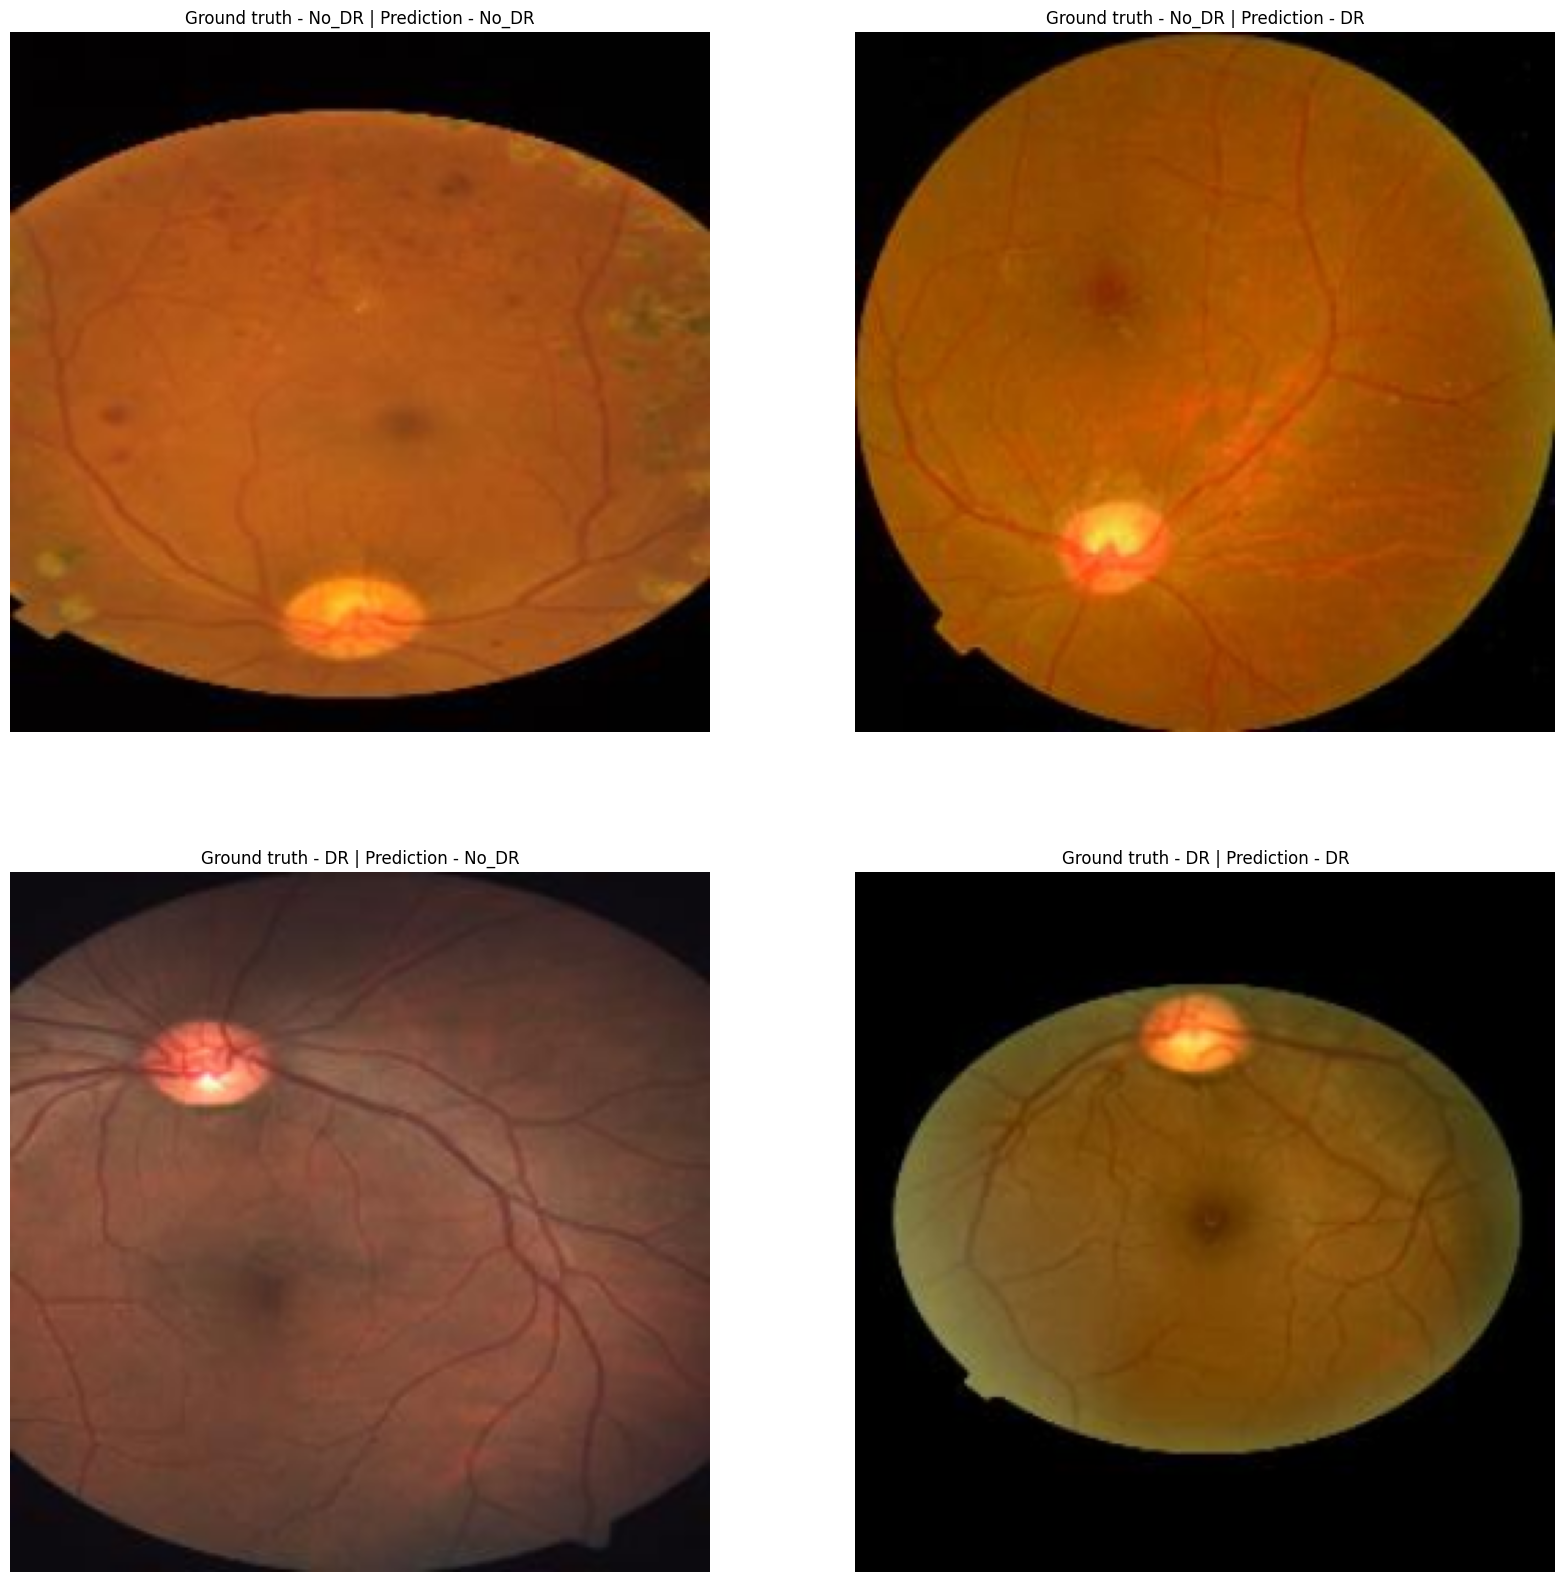

In [20]:
session.confusion_matrix()